# Lunar Mining

Mining robots scan the surface of the moon for depletable water deposits.

From Wikipedia on [Lunar Resources](https://en.wikipedia.org/wiki/Lunar_resources)
> The Moon bears substantial natural resources which could be exploited in the future. Potential lunar resources may encompass processable materials such as volatiles and minerals, along with geologic structures such as lava tubes that together, might enable lunar habitation. The use of resources on the Moon may provide a means of reducing the cost and risk of lunar exploration and beyond.

In a not so distant future, mankind will have established a permanent base on the moon. To fulfil its demand for water, the Earth Space Agency (ESPA) has decided to deploy a fleet of autonomous water-ice mining robots. These robots are designed to first analyze areas for possible water deposits. Detected deposits will be mined, and ice/water will be shipped and stored in the base station. It is a race against time for life and death, because the astronauts are very thirsty.

![The Moon](1136px-FullMoon2010.jpg){: .center}

<p align="center">
<i><a href="https://en.wikipedia.org/wiki/Moon">Full moon photograph</a> taken 10-22-2010 from Madison, Alabama, USA; CC BY-SA 3.0</i>
</p>

ESPA has ordered their process specialists to work out a simulation model of the mining process. With the simulation, the number of mining robots needed to supply the base with enough water must be determined. Also, water production rates shall be estimated. 

ESPA simulation engineers have to solve two very typical tasks in industrial engineering

1. Capacity Planning (number of mining robots needed)
2. Forecast of Production KPIs (tons of water/day)


## Simulation Model

There is a complex interplay of rate-limited processes (transport, search, mining), limited resources and the harsh realities of deep space. The latter is abstracted away in the model as it does not contribute to model performance

* While the specific locations of ice-deposits are unknown, their average distribution and size on the moon had been determined already using a [satellite](https://blog.jatan.space/p/how-nasa-and-chandrayaan-discovered-water-on-the-moon) equipped with the onboard radar, ultraviolet detectors as well as a neutron spectrometer
* Small harvester robots are being deployed from a central depot to scan the lunar surface for water deposits
* When finding a depot they deplete it
* They have a limited storage capacity (100kg), so they will need to shuttle the cargo to the base
* The base will consume water constantly (exponentially distributed with a mean of 5 kg/h)
* The base has an initial deposit of 100kg water (which was shipped to the moon very expensively with rockets from earth)
* Idle harvesters will consult the base for nearby deposits discovered by other units

The complete model definition can be found [here](https://github.com/holgerbrandl/kalasim/blob/master/simulations/lunar-mining/src/main/kotlin/org/kalasim/demo/moon/LunarMining.kt). As an example, we inspect the unloading process of water at the base

```kotlin
fun unload() = sequence {
    moveTo(base.position)

    val unloadingUnitsPerHours = 20  // speed of unloading

    // unloading time correlates with load status
    currentState = UNLOADING
    hold((tank.level / unloadingUnitsPerHours).roundToInt().hours,
         "Unloading ${tank.level} water units")
         
    // put the water into the refinery of the base
    put(get<Base>().refinery, tank.level)
 
     // empty the tank
    take(tank, tank.level)

    activate(process = Harvester::harvesting)
}
```
Modelled as [process definition](../component.md#process-definition), it can be easily started with [`activate()`](../component.md#activate).

A state variable `currentState` allows for later analysis about what the robots were doing. Unloading is actually separated over 2 independent resources:

* the tank of the mining robot
* the refinery of the base

Both are modelled as [depletable resource](../resource.md#depletable-resources), so they can be consumed and refilled with `take()` and `put()` respectively.

Once water unloading is complete, another sub-process of the ice harvester is activated: It's going back into harvesting mode, i.e. the robot is returning to its last mined deposit to continue ice collection.

![](lunar_mining_files/lunar_mining_domain_model.png)

<p align="center">
<i>API surface of the lunar mining simulation model</i>
</p>




## Process Animation

The model can be expressed easily in approximately 200 lines of [process definitions](../component.md#process-definition) in [`LunarMining.kt`](https://github.com/holgerbrandl/kalasim/blob/master/simulations/lunar-mining/src/main/kotlin/org/kalasim/demo/moon/LunarMining.kt). Howvever, it was not initially clear, if the intended dynamics were implemented correctly. [Process animation](animation.md) comes to resuce, as it allows to debug the model visually.

A process animation was developed as well to better understand the spatio-temporal dynamics of the model. In [LunarMiningHQ.kt](https://github.com/holgerbrandl/kalasim/blob/master/simulations/lunar-mining/src/main/kotlin/org/kalasim/demo/moon/LunarMiningHQ.kt) the animation of this process is worked out in just about 150 lines of code.


<div class="video-wrapper">
  <iframe width="700" height="500" src="https://www.youtube.com/embed/r2igemRWk7s" frameborder="0" allowfullscreen></iframe>
</div>

We used different capabilties of the [animation system](animation.md) (based on [OPENRNDR](https://openrndr.org/))

* Image background to draw a map of the moon
* Dynamic shape contour to indicate loading status of the harvesters
* SVG objects for harvesters and base
* Automatic video recording
* Text and simple shapes to draw deposits and process properties 



## Supply Optimization

To assess how many ice harvesters are needed to ensure base survival we can play what-if with our model. We do so in a fully reproducible manner right in place here. First we load `kalasim` and import required classes.

In [3]:
@file:Repository("*mavenLocal")

%useLatestDescriptors on
%use kalasim(0.7.94)
%use kravis(0.8.4)

@file:DependsOn("org.kalasim.demo:lunar-mining:1.0-SNAPSHOT")

import org.kalasim.demo.moon.*
import krangl.asDataFrame
import krangl.bindRows


Next we can run the simulation multiple times with different numbers of robots and compare the outcome.

In [4]:
val sims = List(9) { numHarvesters ->
    List(100) {
        LunarMining(numHarvesters+1, 15, false, it).apply { run(60*60) }
    }
}.flatten()

To work with the data, we first combine the refinery water level timelines into a data-frame.

In [5]:
val waterSupply = sims.withIndex().map { (idx, sim) ->
    sim.base.refinery.levelTimeline//.statistics()
        .stepFun()
        .asDataFrame()
        .addColumn("num_harvesters") { sim.harvesters.size }
        .addColumn("run") { idx }
}.bindRows()

First, we can study the water level in the central refinery across all the 100 simuation runs.    

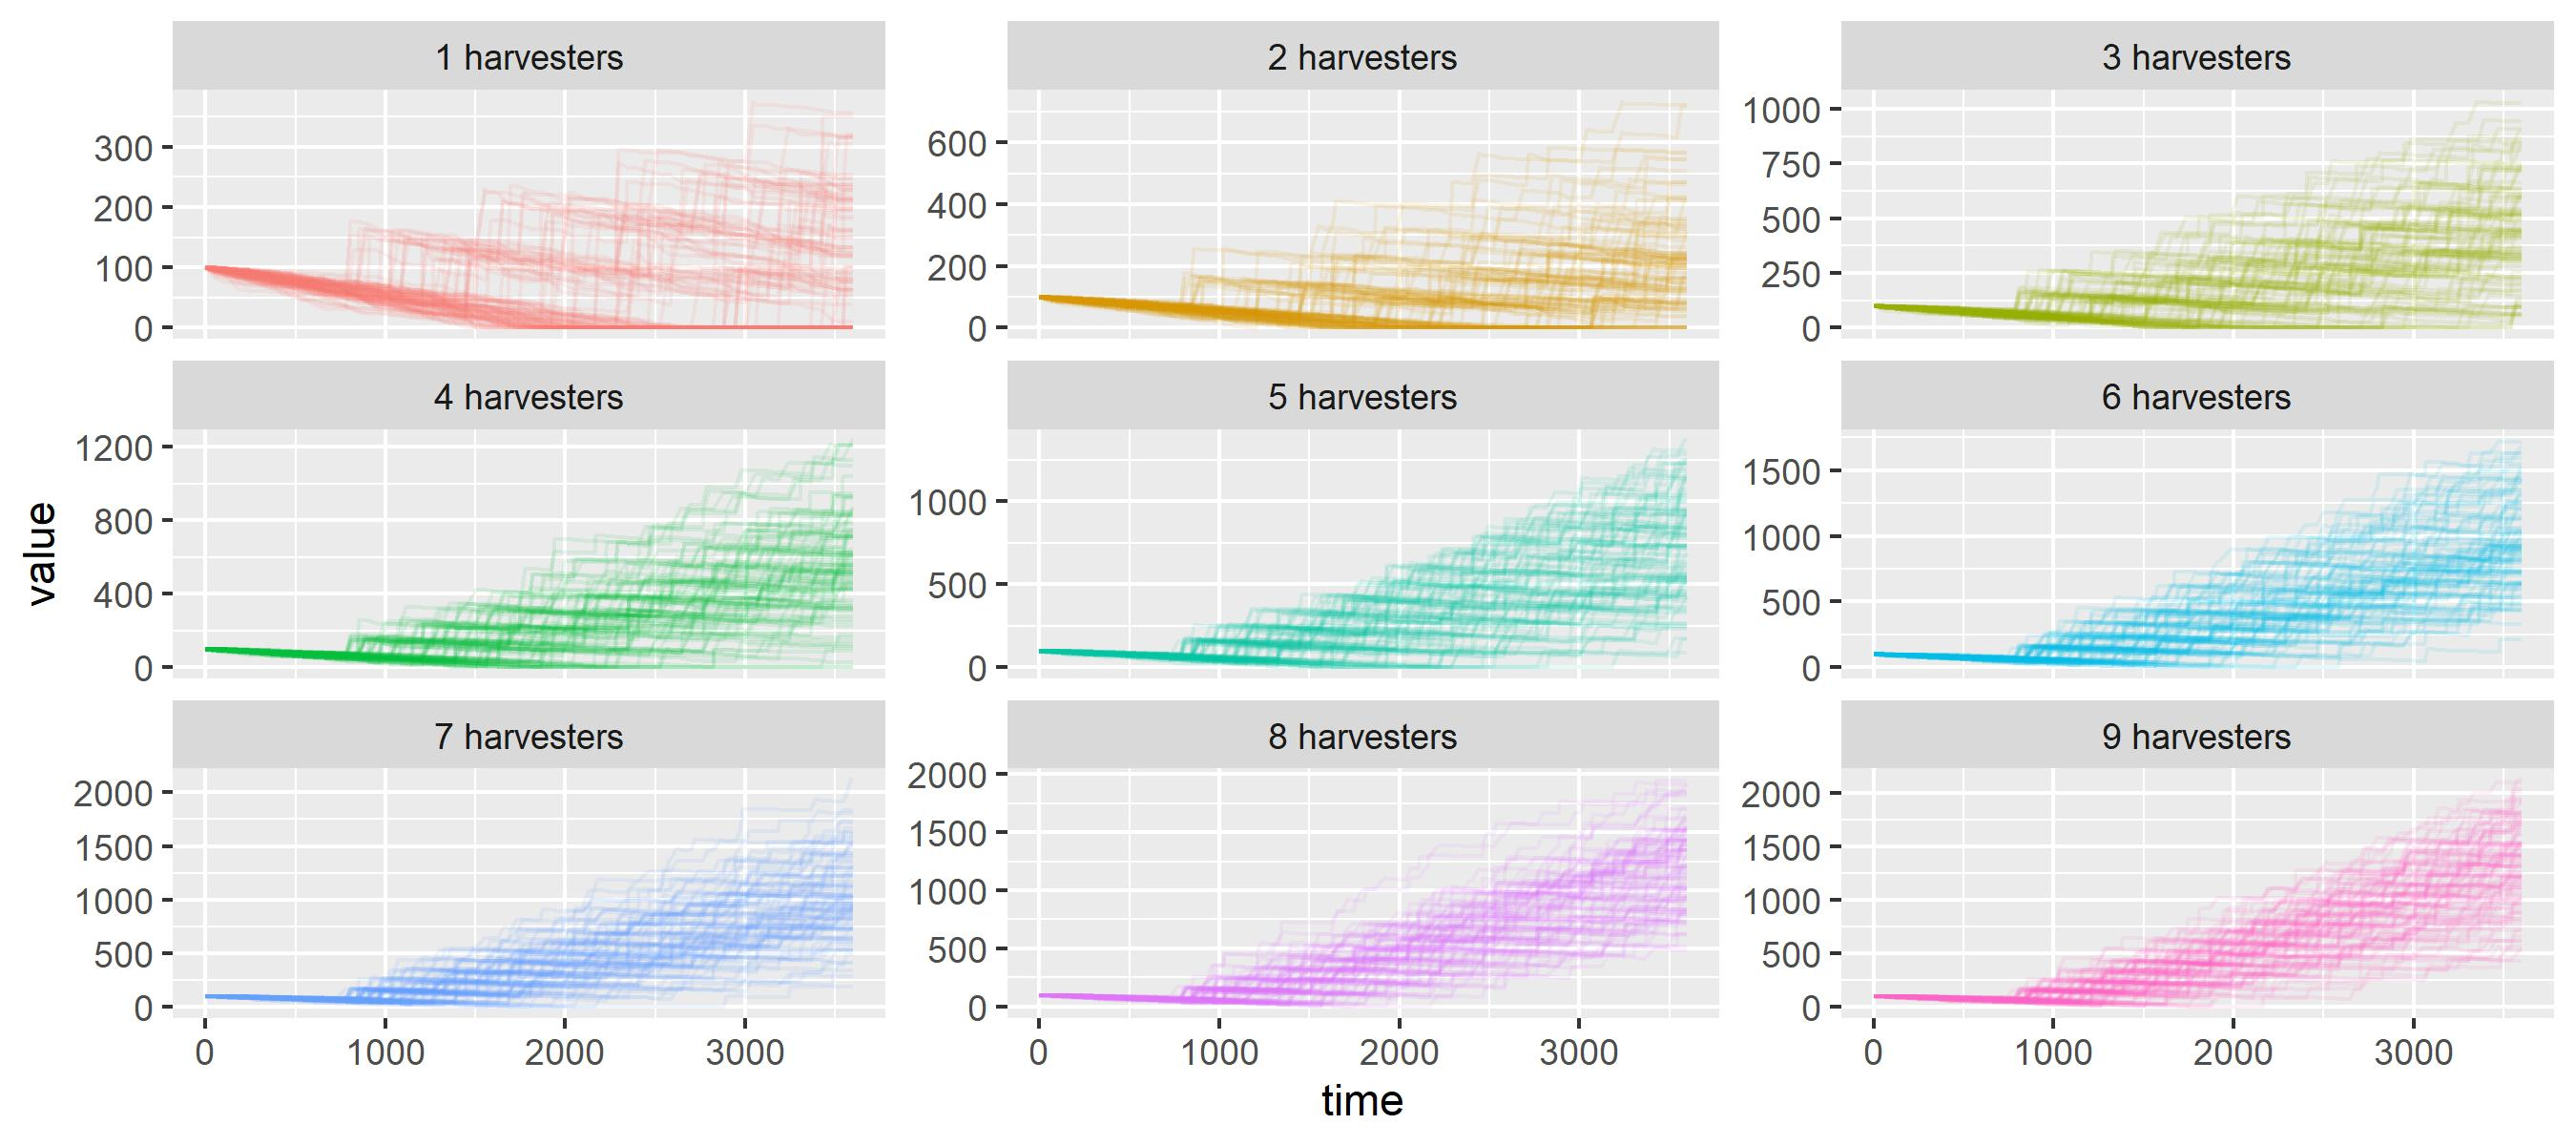

In [6]:
waterSupply
     .addColumn("num_harvesters"){
        it["num_harvesters"].map<Int>{ it.toString()+ " harvesters"}
     }
    .plot(x = "time", y = "value", group="run", color="num_harvesters")
    .geomLine( alpha = .1)
    .facetWrap("num_harvesters", scales=FacetScales.free_y)
    .guides(color=LegendType.none)

With more ice harvesters working around the base, supply of water is ensured. Initially there is a phase, were no deposits are yet discovererd, so the base is under a severe risk of running dry. To assess how often this happens, we count the number of runs per harvester where the base's refinery was depleted.  

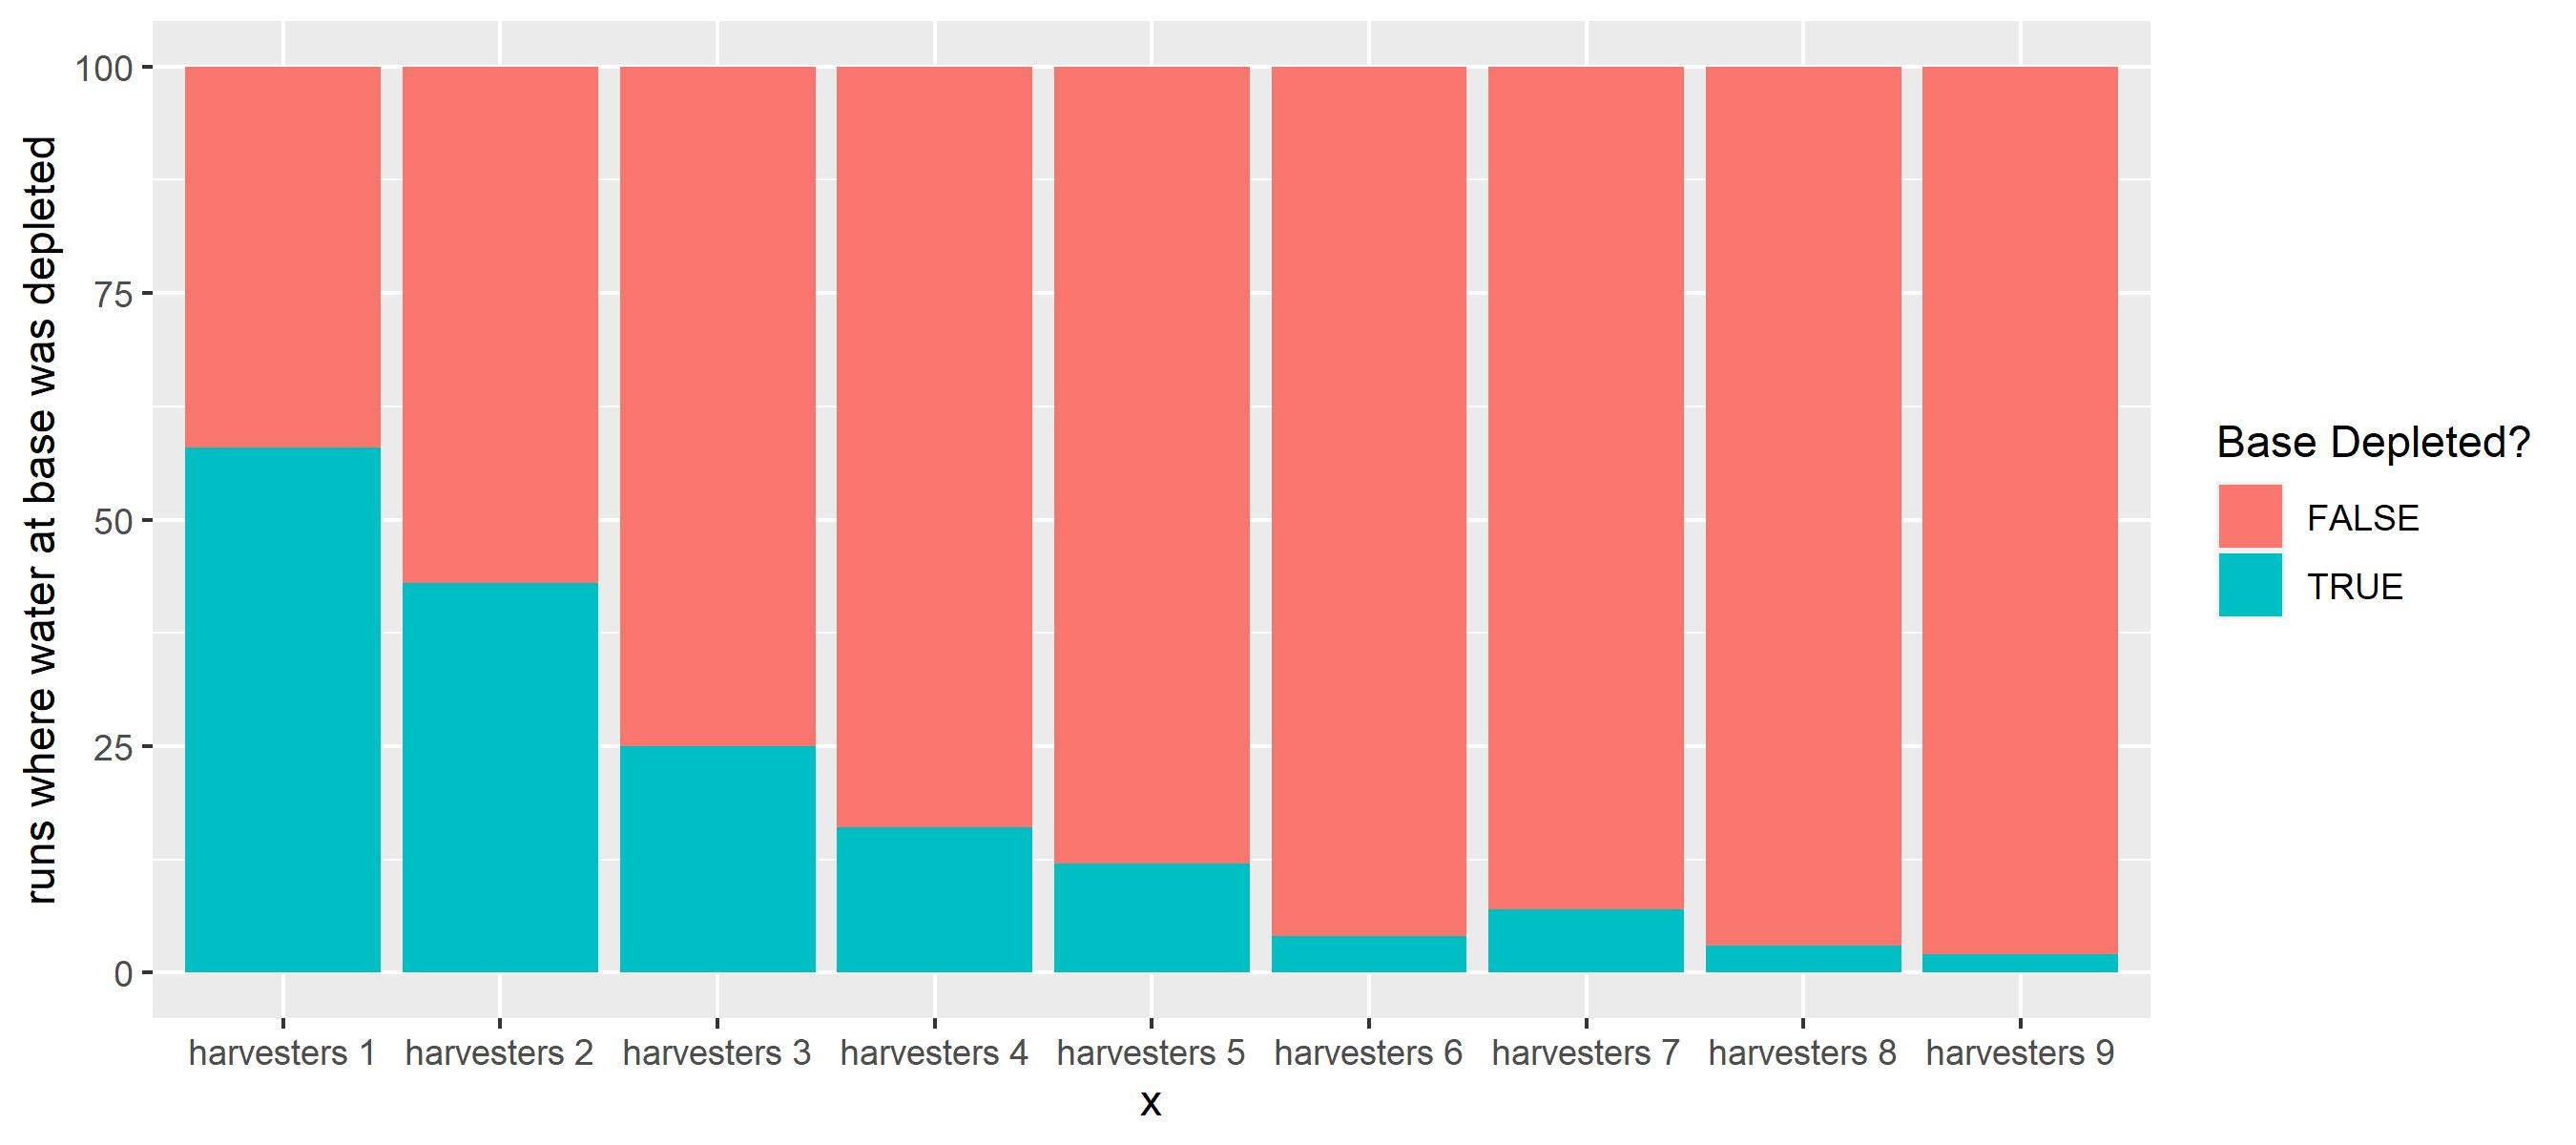

In [8]:
sims.map { sim ->
    ("h "+sim.harvesters.size) to
            sim.base.refinery.levelTimeline.statistics().min
}.plot(x={ first}, fill={second==0.0})
    .geomBar()
    .labs(x="# harvesters", y="# simulation runs", fill = "Base Depleted?")


As shown in the figure, it turns out, that with >=5 ice harvestering robots, the risk of water supply depletion at the base station is within an acceptable range.

We have just analyzed our lunar mining model using controlled randomization, and have performed a basic capacity analysis.


## Exercise: Maintenance Module

The model could be extended to model robot health as well

* Occasional meteoroids hits will affect the harvester health status (with the varying amount, and which eventually will lead to robot outage)
* Harvesters health is slowly decreasing while depleting deposits
* Harvesters can be repaired in a special maintenance depot (which is a bit far off), so they must sure to get their in time because picking up broken robots in the field is very time consumin & expensive


## Summary

ESPA is relieved. The simulation model showed that sufficient water-supplies can be gathered with 5 mining robots. The astronauts can even take a shower every Sunday from now on.

Using a discrete event simulation model built with `kalasim`, we have animated the process and have analyzed its statistical properties.